/Users/alexiskaldany/projects/transformers_ts/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


mps


[Text(15677.0, 0, '2012-12-03'),
 Text(16041.0, 0, '2013-12-02'),
 Text(16405.0, 0, '2014-12-01'),
 Text(16769.0, 0, '2015-11-30'),
 Text(17133.0, 0, '2016-11-28'),
 Text(17497.0, 0, '2017-11-27'),
 Text(17861.0, 0, '2018-11-26'),
 Text(18225.0, 0, '2019-11-25'),
 Text(18589.0, 0, '2020-11-23'),
 Text(18953.0, 0, '2021-11-22'),
 Text(19317.0, 0, '2022-11-21')]

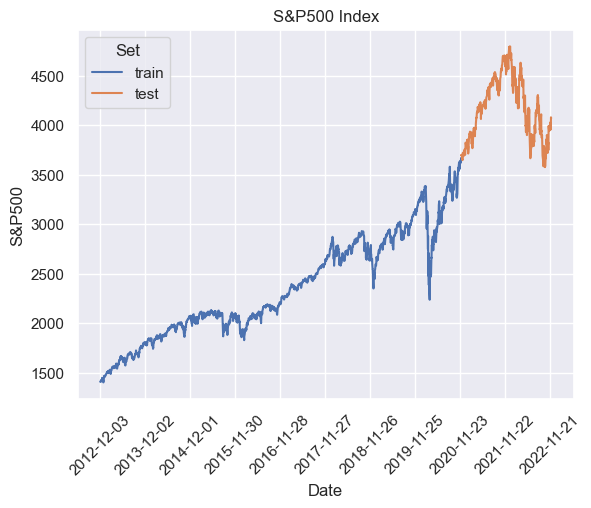

In [1]:
from pathlib import Path
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import Adam
from sklearn.preprocessing import MinMaxScaler

device = torch.device("mps" if torch.has_mps else "cpu")
print(device)
sns.set(style="darkgrid")
COMPANIES = Path("data/sp500_companies.csv").absolute()
INDEX = Path("data/sp500_index.csv").absolute()
STOCKS = Path("data/sp500_stocks.csv").absolute()
OUTPUT_PATH = Path("train_scaled_lstm.csv").absolute()
TEST_OUTPUT_PATH = Path("test_scaled_lstm.csv").absolute()
TRAIN_TEST_SPLIT: int = 0.8
stock_df = pd.read_csv(INDEX)
stock_length = len(stock_df)
stock_df["Set"] = ["train" if i < TRAIN_TEST_SPLIT * len(stock_df) else "test" for i in range(len(stock_df))]
stock_df["Date"] = pd.to_datetime(stock_df["Date"])
stock_df["Year"] = stock_df["Date"].dt.year
basic = sns.lineplot(data=stock_df, x="Date", y="S&P500", hue="Set")
basic.set_title("S&P500 Index")
basic.set_xticks(stock_df["Date"][::int(stock_length/10)])
basic.set_xticklabels(stock_df["Date"][::int(stock_length/10)].dt.strftime("%Y-%m-%d"), rotation=45)

In [2]:
# Params

SEQ_LEN: int = 15 # Number of days to look back
TARGET_LEN = 1 # Number of days to predict
HIDDEN_SIZE = 128 # Number of neurons in the LSTM layer
NUM_LAYERS = 4 # Number of LSTM layers
EPOCHS = 5 # Number of epochs to train 
LR = 2e-5 # Learning rate
LOSS_FUNCTION = nn.MSELoss() # Loss function


In [3]:
"""Scaling the input data""" 



'Scaling the input data'

In [4]:
""" 
Dataset for timeseries data
"""

class TS_Dataset(Dataset):
    def __init__(self, data, seq_len, target_len, date, transform=None):
        self.data = data
        self.date = date
        self.seq_len = seq_len
        self.target_len = target_len
        self.transform = transform

    def __len__(self):
        return len(self.data) - self.seq_len - self.target_len

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        x = self.data[idx:idx+self.seq_len]
        y = self.data[idx+self.seq_len:idx+self.seq_len+self.target_len]
        z = self.date[idx+self.seq_len:idx+self.seq_len+self.target_len]
        if self.transform:
            x = self.transform(x)
            y = self.transform(y)
        return x, y, z

scaler = MinMaxScaler(feature_range=(-1, 1))
input_df = stock_df.copy()
train_df = input_df[input_df["Set"] == "train"].copy()
train_df["S&P500"] = scaler.fit_transform(train_df["S&P500"].values.reshape(-1, 1))
train_ds = TS_Dataset(train_df["S&P500"].values, SEQ_LEN, TARGET_LEN, train_df["Date"].values)

# Basic LSTM

In [5]:

class LSTM(nn.Module):
    def __init__(self, seq_len, hidden_size, num_layers, target_len):
        super(LSTM, self).__init__()
        self.seq_len = seq_len
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.target_len = target_len
        self.lstm = nn.LSTM(input_size=seq_len, hidden_size=hidden_size, num_layers=num_layers)
        # self.relu = nn.ReLU()
        self.linear = nn.Linear(in_features=hidden_size, out_features=target_len)
        self.hidden_cell = (torch.zeros(self.num_layers,1,self.hidden_size),
                            torch.zeros(self.num_layers,1,self.hidden_size))
    def forward(self, x):
        x_input = x.view(1, self.seq_len)
        # print(x_input.shape)
        x_input = x_input.view(1, 1, self.seq_len)
        # print(x_input.shape)
        # print(f"input.size(-1) = {x_input.size(-1)}")
        out, (hn, cn) = self.lstm(x_input, self.hidden_cell)
        out = self.linear(out.view(self.target_len, -1))
        return out[-1]
  
LSTM_MODEL = LSTM(SEQ_LEN, HIDDEN_SIZE, NUM_LAYERS, TARGET_LEN)
optimizer = torch.optim.Adam(LSTM_MODEL.parameters(), lr=LR)
print(LSTM_MODEL)

LSTM(
  (lstm): LSTM(15, 128, num_layers=4)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)


In [6]:
output_df = pd.DataFrame(columns=["Date","Epoch", "Loss", "MSE", "Predicted", "Actual"])

In [7]:
""" 
Training loop
"""
train_ds_len = train_ds.__len__()
end_train_index = int(train_ds_len - TARGET_LEN)
start_train_index = SEQ_LEN
for epoch in range(EPOCHS):
    for index in range(start_train_index, end_train_index):
        x, y, z = train_ds[index]
        x = torch.from_numpy(x).float()
        # print(x)
        # print(type(x))
        # print(x.shape)
        # print(x.size(-1))
        y = y.reshape(1, TARGET_LEN)
        y = torch.from_numpy(y).float()[0]
        output = LSTM_MODEL(x)
        # print(f"y : {y}")
        # print(f"y shape = {y.shape}")
        # print(f"output shape = {output.shape}")
        loss = LOSS_FUNCTION(output, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        predicted = output.detach().numpy()[0]
        actual = y.detach().numpy()[0]
        # print(f"predicted = {predicted}")
        # print(f"actual = {actual}")
        mse = np.mean((predicted - actual) ** 2)
        # print(f"mse = {mse}")
        output_df = pd.concat([output_df, pd.DataFrame({"Date": z, "Epoch": epoch, "Loss": loss.item(), "MSE": mse, "Predicted": predicted, "Actual": actual})])
        if index % 100 == 0:
            # print(f"predicted = {predicted}")
            # print(f"actual = {actual}")
            print(f"Epoch: {epoch} | Iteration: {index} | Loss: {loss} | MSE: {mse} | Predicted: {predicted} | Actual: {actual}")
    output_df.to_csv(OUTPUT_PATH, index=False)
    


Epoch: 0 | Iteration: 100 | Loss: 0.5291970372200012 | MSE: 0.529197049866653 | Predicted: -0.03971416503190994 | Actual: -0.7671734690666199
Epoch: 0 | Iteration: 200 | Loss: 0.4661632478237152 | MSE: 0.4661632526981272 | Predicted: -0.061231695115566254 | Actual: -0.7439931631088257
Epoch: 0 | Iteration: 300 | Loss: 0.24338789284229279 | MSE: 0.24338789946165207 | Predicted: -0.08787566423416138 | Actual: -0.5812192559242249
Epoch: 0 | Iteration: 400 | Loss: 0.13988113403320312 | MSE: 0.13988113686890813 | Predicted: -0.12522104382514954 | Actual: -0.499227911233902
Epoch: 0 | Iteration: 500 | Loss: 0.05490071699023247 | MSE: 0.054900715755966445 | Predicted: -0.1843746304512024 | Actual: -0.41868364810943604
Epoch: 0 | Iteration: 600 | Loss: 0.011465394869446754 | MSE: 0.011465395117969734 | Predicted: -0.25877857208251953 | Actual: -0.3658551573753357
Epoch: 0 | Iteration: 700 | Loss: 0.0027450004126876593 | MSE: 0.0027450003550919533 | Predicted: -0.4380377531051636 | Actual: -0.4

[Text(15721.0, 0, '2013-01-16'),
 Text(16085.0, 0, '2014-01-15'),
 Text(16449.0, 0, '2015-01-14'),
 Text(16813.0, 0, '2016-01-13'),
 Text(17177.0, 0, '2017-01-11'),
 Text(17541.0, 0, '2018-01-10'),
 Text(17906.0, 0, '2019-01-10'),
 Text(18270.0, 0, '2020-01-09'),
 Text(15757.0, 0, '2013-02-21'),
 Text(16121.0, 0, '2014-02-20'),
 Text(16485.0, 0, '2015-02-19'),
 Text(16849.0, 0, '2016-02-18'),
 Text(17212.0, 0, '2017-02-15'),
 Text(17576.0, 0, '2018-02-14'),
 Text(17941.0, 0, '2019-02-14'),
 Text(18305.0, 0, '2020-02-13'),
 Text(15791.0, 0, '2013-03-27'),
 Text(16155.0, 0, '2014-03-26'),
 Text(16519.0, 0, '2015-03-25'),
 Text(16883.0, 0, '2016-03-23'),
 Text(17247.0, 0, '2017-03-22'),
 Text(17611.0, 0, '2018-03-21'),
 Text(17976.0, 0, '2019-03-21'),
 Text(18340.0, 0, '2020-03-19'),
 Text(15826.0, 0, '2013-05-01'),
 Text(16190.0, 0, '2014-04-30'),
 Text(16554.0, 0, '2015-04-29'),
 Text(16918.0, 0, '2016-04-27'),
 Text(17282.0, 0, '2017-04-26'),
 Text(17646.0, 0, '2018-04-25'),
 Text(1801

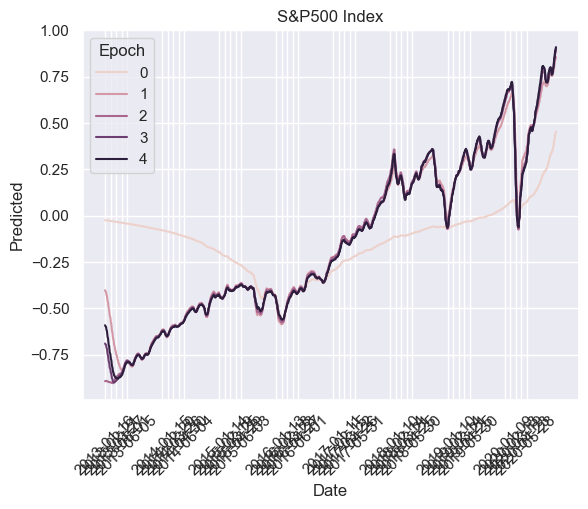

In [8]:
"""Graphing Predictions"""
epoch_predictions = sns.lineplot(x="Date", y="Predicted", hue="Epoch", data=output_df)
epoch_predictions.set_title("S&P500 Index")
epoch_predictions.set_xticks(output_df["Date"][::int(stock_length/10)])
# epoch_predictions.set_xticklabels(output_df["Date"][::int(stock_length/10)].dt.strftime("%Y-%m-%d"), rotation=45)

In [23]:
"""testing loop"""
scaler = MinMaxScaler(feature_range=(-1, 1))
test_df = input_df[input_df["Set"] == "test"].copy()
test_df["S&P500"] = scaler.fit_transform(test_df["S&P500"].values.reshape(-1, 1))
test_ds = TS_Dataset(test_df["S&P500"].values, SEQ_LEN, TARGET_LEN, test_df["Date"].values)
print(test_ds.__getitem__(0))
start_test_index = SEQ_LEN
print(start_test_index)
end_test_index = int(test_ds.__len__() - TARGET_LEN)
print(end_test_index)
test_output_holder = pd.DataFrame(columns=["Date","Predicted", "Actual"])
for index in range(start_test_index, end_test_index):
    x, y, z = test_ds[index]
    x = torch.from_numpy(x).float()
    print(y)
    y = y.reshape(1, TARGET_LEN)
    y = torch.from_numpy(y).float()[0]
    output = LSTM_MODEL(x)
    # loss = LOSS_FUNCTION(output, y)
    predicted = output.detach().numpy()[0]
    actual = y.detach().numpy()[0]
    # unscaled_predicted = scaler.inverse_transform(predicted.reshape(-1, 1))
    # unscaled_actual = scaler.inverse_transform(actual.reshape(-1, 1))
    test_output_holder = pd.concat([test_output_holder, pd.DataFrame({"Date": z, "Predicted": predicted, "Actual": actual})])
print(len(test_output_holder))
print(len(test_df))
test_df = test_df.iloc[start_test_index:end_test_index]
print(len(test_df))
test_df["Predicted"] = scaler.inverse_transform(test_output_holder["Predicted"].values.reshape(-1, 1))
test_df["Actual"] = scaler.inverse_transform(test_output_holder["Actual"].values.reshape(-1, 1))
test_df.to_csv(TEST_OUTPUT_PATH, index=False)

(array([-0.79977532, -0.81151755, -0.7946422 , -0.84290669, -0.85064738,
       -0.85825687, -0.88444729, -0.80715522, -0.79641337, -0.76146548,
       -0.78289997, -0.80666322, -0.81922544, -0.81471551, -0.79331382]), array([-0.74034259]), array(['2020-12-28T00:00:00.000000000'], dtype='datetime64[ns]'))
15
486
[-0.54930178]
[-0.54730101]
[-0.56632473]
[-0.54354546]
[-0.55295893]
[-0.71507056]
[-0.65503104]
[-0.77497889]
[-0.67720351]
[-0.59118677]
[-0.58485646]
[-0.51668266]
[-0.49193542]
[-0.44476971]
[-0.45192]
[-0.45413397]
[-0.44347413]
[-0.41321657]
[-0.41689011]
[-0.41895648]
[-0.44742647]
[-0.45933269]
[-0.50887637]
[-0.50088969]
[-0.42863234]
[-0.58621764]
[-0.61604881]
[-0.46735218]
[-0.51906062]
[-0.60199421]
[-0.68604298]
[-0.56555394]
[-0.59932105]
[-0.51061475]
[-0.4722885]
[-0.40582028]
[-0.39926037]
[-0.35727698]
[-0.36749403]
[-0.34878191]
[-0.4449829]
[-0.44885325]
[-0.4037703]
[-0.45308438]
[-0.48814707]
[-0.45472436]
[-0.34809312]
[-0.35375104]
[-0.37431633]
[-0.35

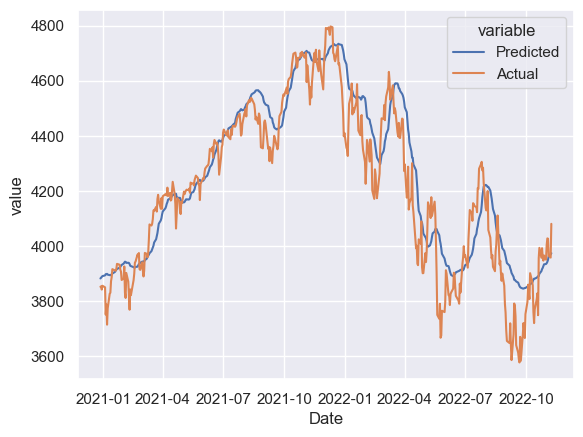

In [24]:
test_melted_df = pd.melt(test_df, id_vars=["Date"], value_vars=["Predicted", "Actual"], var_name="variable", value_name="value")
testing_graph = sns.lineplot(x="Date", y="value", hue="variable", data=test_melted_df)